#Preprocessing

In [ ]:
pip install -U spacy

In [ ]:
!spacy download en_core_web_sm

In [3]:
import spacy
from spacy.tokenizer import Tokenizer
#Once you have a GPU-enabled installation, the best way to activate it is to call 
spacy.prefer_gpu()

# Write code here to load spaCy for french
spacy_nlp = spacy.load("en_core_web_sm")

In [4]:
spacy_nlp = spacy.load("en_core_web_sm")

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, f1_score
from sklearn.compose import ColumnTransformer


from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.svm import SVC
import xgboost as xgb
from scipy.stats import skew
import plotly.express as px

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train_df = pd.read_csv('/content/drive/MyDrive/Ensemble Learning/df_all_features_tfidf.csv', index_col=0)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,muslim,gay,round,good,radical,bad,mkr,rape,stupid,lot
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208295,...,0,0,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [29]:
if 'cyberbullying_type' in train_df.columns:
  x = True
x

True

In [4]:
train_df['not_cyberbullying'] = (train_df.cyberbullying_type == "not_cyberbullying").astype(int)
train_df = train_df.drop(['cyberbullying_type'], axis=1)
train_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,gay,round,good,radical,bad,mkr,rape,stupid,lot,not_cyberbullying
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,1,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,1,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.208295,...,0,0,0,0,0,0,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,1


In [7]:
train_x = train_df.drop(['not_cyberbullying','tweet_text'], axis = 1)
## transforming the y column so that it works with the rest of the model
train_y = train_df['not_cyberbullying']
train_y = np.array(train_y)
train_y = np.transpose(train_y)
train_y = train_y.ravel()

In [8]:
from collections import Counter
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2, random_state=100)
print(f"Train number of observations: {Counter(y_train)}")
print(f"Test target number of observations: {Counter(y_test)}")

Train number of observations: Counter({0: 31810, 1: 6343})
Test target number of observations: Counter({0: 7937, 1: 1602})


In [ ]:
!pip install xgboost

In [10]:
from xgboost import XGBClassifier

In [11]:
def balance_test(X_train, X_test, y_train, y_test, class_weight = None, threshold=False):
    #Set the class weight
    if class_weight:    
        model =  XGBClassifier(sample_weight = class_weight)
    else:
        model = XGBClassifier()
    #Train
    model.fit(X_train, y_train)

    #Test
    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)
    fpr0, tpr0, thresholds = roc_curve(y_test, y_score[:, 1])
    roc_auc0 = auc(fpr0, tpr0)
    
    # Calculate the best threshold
    best_threshold = None
    if threshold:
        J = tpr0 - fpr0
        ix = argmax(J) # take the value which maximizes the J variable
        best_threshold = thresholds[ix]
        # adjust score according to threshold.
        y_score = np.array([[1, y[1]] if y[0] >= best_threshold else [0, y[1]] for y in y_score])
        
    # Plot metrics 
    plot_roc(y_test, y_score)
    #plt.show()
    
    plot_precision_recall(y_test, y_score)
    #plt.show()
    
    plot_cumulative_gain(y_test, y_score)
    #plt.show()
    
    plot_lift_curve(y_test, y_score)
    #plt.show()
    
    # Print a classification report
    print(classification_report(y_test,y_pred))
    return roc_auc0,fpr0,tpr0, best_threshold

    print('Overall Precision score %s' % precision_score(y_test, y_pred))
    print('Overall Recall score %s' % recall_score(y_test, y_pred))
    print('Overall F1-score score %s' % f1_score(y_test, y_pred))
    print('Overall Accuracy score %s' % accuracy_score(y_test, y_pred))
        
    
    

In [ ]:
!pip install scikit-plot

In [13]:
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_cumulative_gain
from scikitplot.metrics import plot_lift_curve
from sklearn.metrics import roc_curve, auc, roc_auc_score

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7937
           1       0.69      0.27      0.39      1602

    accuracy                           0.86      9539
   macro avg       0.78      0.62      0.66      9539
weighted avg       0.84      0.86      0.83      9539



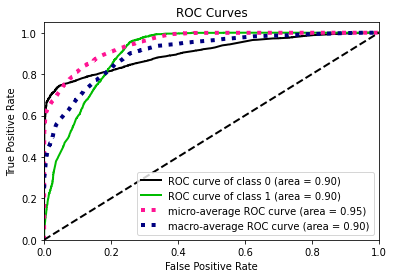

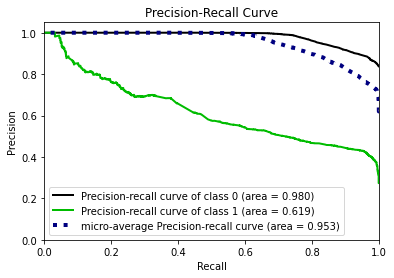

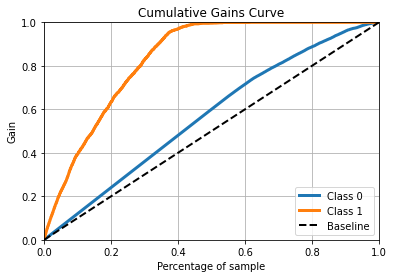

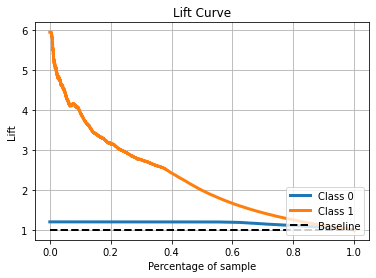

In [14]:
#Performance of imbalanced dataset
roc_auc_imb,fpr_imb,tpr_imb, _ = balance_test(X_train, X_test, y_train, y_test)

In [15]:
#Oversampling
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=30)
X_over, y_over = over_sampler.fit_resample(X_train, y_train)
print(f"Trainset number of observations: {Counter(y_over)}")
print(f"Test set target number of observations: {Counter(y_test)}")

Trainset number of observations: Counter({0: 31810, 1: 31810})
Test set target number of observations: Counter({0: 7937, 1: 1602})


              precision    recall  f1-score   support

           0       0.99      0.73      0.84      7937
           1       0.42      0.97      0.59      1602

    accuracy                           0.77      9539
   macro avg       0.71      0.85      0.71      9539
weighted avg       0.90      0.77      0.80      9539



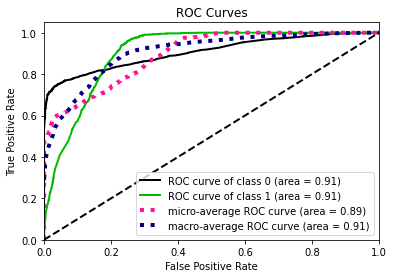

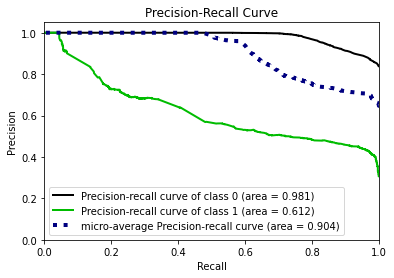

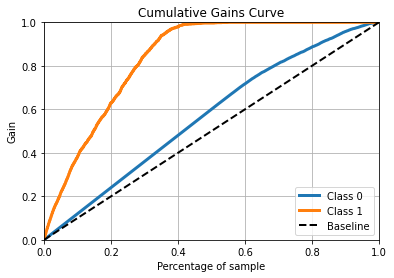

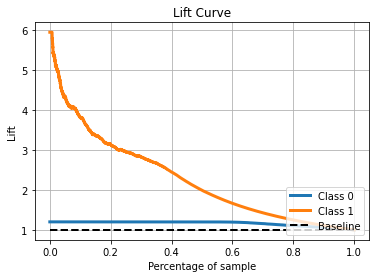

In [16]:
roc_auc_over,fpr_over,tpr_over, _ = balance_test(X_over, X_test, y_over, y_test)

In [17]:
#undersample the big dataset 
from imblearn.under_sampling import RandomUnderSampler

under_sampler = RandomUnderSampler(random_state=42)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)
print(f"Trainset number of observations: {Counter(y_under)}")
print(f"Test set target number of observations: {Counter(y_test)}")

Trainset number of observations: Counter({0: 6343, 1: 6343})
Test set target number of observations: Counter({0: 7937, 1: 1602})


              precision    recall  f1-score   support

           0       0.99      0.72      0.83      7937
           1       0.41      0.98      0.58      1602

    accuracy                           0.76      9539
   macro avg       0.70      0.85      0.71      9539
weighted avg       0.90      0.76      0.79      9539



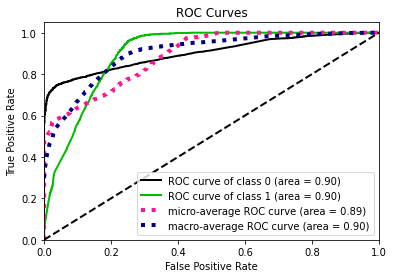

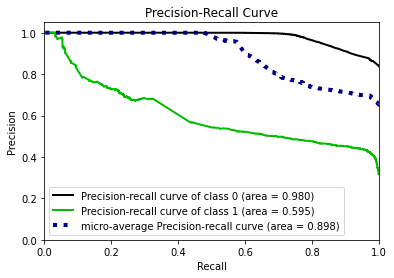

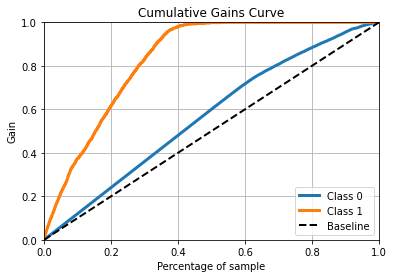

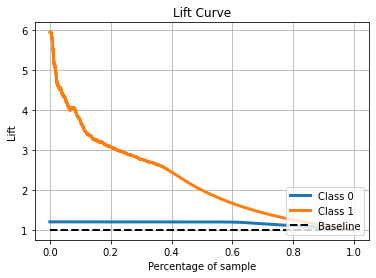

In [18]:
roc_auc_under,fpr_under,tpr_under , _ = balance_test(X_under, X_test, y_under, y_test)

Trainset number of observations: Counter({0: 6343, 1: 6343})
Test set target number of observations Counter({0: 7937, 1: 1602})
              precision    recall  f1-score   support

           0       0.86      0.37      0.52      7937
           1       0.18      0.70      0.29      1602

    accuracy                           0.43      9539
   macro avg       0.52      0.53      0.40      9539
weighted avg       0.74      0.43      0.48      9539



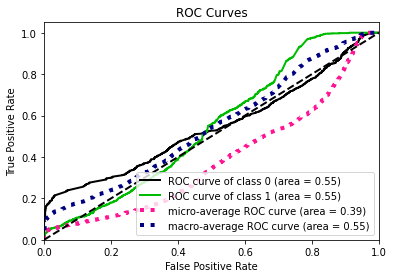

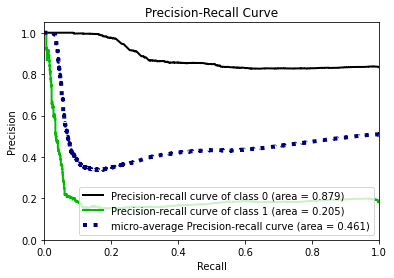

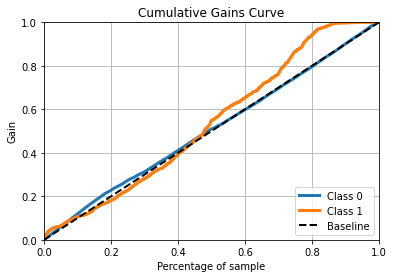

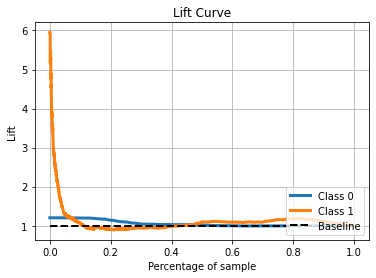

In [19]:
#Same analysis, using NearMiss
from imblearn.under_sampling import NearMiss

under_sampler = NearMiss()
X_under1, y_under1 = under_sampler.fit_resample(X_train, y_train)
print(f"Trainset number of observations: {Counter(y_under1)}")
print(f"Test set target number of observations {Counter(y_test)}")

roc_auc_under1,fpr_under1,tpr_under1, _  = balance_test(X_under1, X_test, y_under1, y_test)

In [20]:
#Using class_weight
n= Counter(y_train)
ratio = int(n[0]/n[1])
n

Counter({0: 31810, 1: 6343})

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7937
           1       0.69      0.27      0.39      1602

    accuracy                           0.86      9539
   macro avg       0.78      0.62      0.66      9539
weighted avg       0.84      0.86      0.83      9539



ValueError: ignored

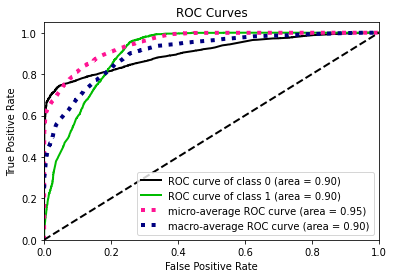

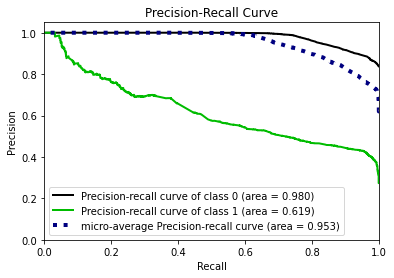

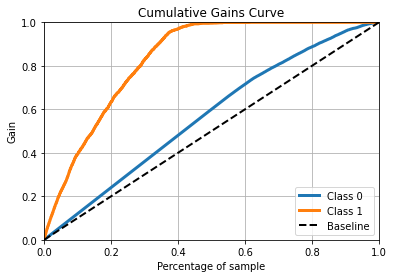

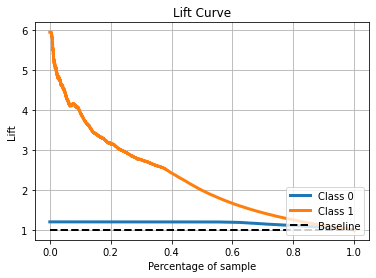

In [21]:
roc_auc_cw,fpr_cw,tpr_cw  = balance_test(X_train, X_test, y_train, y_test, class_weight={0:1, 1:ratio})

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      7937
           1       0.69      0.27      0.39      1602

    accuracy                           0.86      9539
   macro avg       0.78      0.62      0.66      9539
weighted avg       0.84      0.86      0.83      9539

Best Treshold: 0.24162518978118896


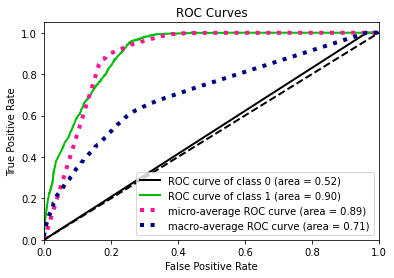

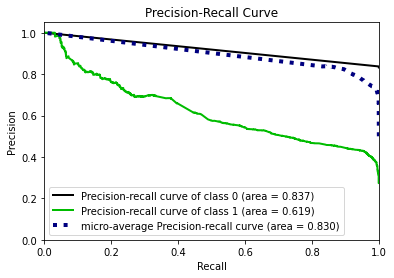

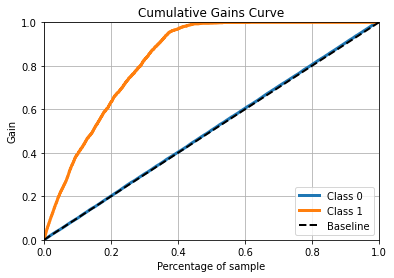

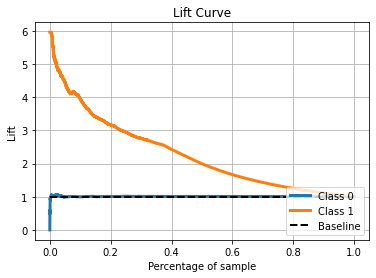

In [22]:
from numpy import argmax
roc_auc_t,fpr_t,tpr_t, thres = balance_test(X_train, X_test, y_train, y_test, threshold=True)
print(f"Best Treshold: {thres}")